In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Identify SLC and OR genes in ORF metadata

In [2]:
profiles = {
    "ORF": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony",
    "CRISPR": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected",
}

In [3]:
orf_metadata = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz", sep="\t"
)

orf_phenotypic_activity = pd.read_csv(
    f'../03.retrieve-annotations/output/phenotypic-activity-{profiles["ORF"]}.csv.gz', usecols = ["Metadata_JCP2022", "below_corrected_p"]
)

orf_metadata = orf_metadata.merge(orf_phenotypic_activity, on="Metadata_JCP2022", how="inner").query("below_corrected_p == True")

In [4]:
orf_slc = list(
    orf_metadata.loc[
        orf_metadata.Metadata_Approved_Symbol.str.startswith("SLC")
        & orf_metadata.Metadata_Gene_Description.str.startswith("solute")
    ].Metadata_Symbol
)

print(len(orf_slc))

171


In [5]:
orf_or = list(
    orf_metadata.loc[
        (
            orf_metadata.Metadata_Approved_Symbol.str.startswith("OR")
            & orf_metadata.Metadata_Gene_Description.str.startswith("olfactory")
        )
    ].Metadata_Symbol
)

print(len(orf_or))

62


In [6]:
orf_genes = list(np.unique(orf_slc + orf_or))

For CRISPRs, the same strategy wouldn't work since they don't have gene descriptions.

In [7]:
pattern = r"OR\d+\w?"

In [8]:
crispr_metadata = pd.read_csv(
    "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz", sep="\t"
)

crispr_phenotypic_activity = pd.read_csv(
    f'../03.retrieve-annotations/output/phenotypic-activity-{profiles["CRISPR"]}.csv.gz', usecols = ["Metadata_JCP2022", "below_corrected_p"]
)

crispr_metadata = crispr_metadata.merge(crispr_phenotypic_activity, on="Metadata_JCP2022", how="inner").query("below_corrected_p == True")

In [9]:
crispr_slc = list(
    crispr_metadata.loc[
        crispr_metadata.Metadata_Approved_Symbol.str.startswith("SLC")
    ].Metadata_Symbol
)

print(len(crispr_slc))

161


In [10]:
crispr_or = list(
    crispr_metadata.loc[
        (
            crispr_metadata.Metadata_Approved_Symbol.str.startswith("OR")
            & crispr_metadata.Metadata_Approved_Symbol.str.contains(pattern)

        )
    ].Metadata_Symbol
)

print(len(crispr_or))

1


In [11]:
crispr_genes = list(np.unique(crispr_slc + crispr_or)) 
crispr_genes.remove("SLC26A10")

In [12]:
orf_similarity_df = pd.read_parquet("cos_sim/cosine_similarities_genes_orf.parquet").loc[orf_genes, orf_genes]

# filter out genes with low correlation with all other genes

tmp = orf_similarity_df.copy()
tmp.values[np.diag_indices_from(tmp)] = 0
cols = np.unique(list(tmp.columns[(tmp.abs() > 0.4).any()]))

orf_similarity_df = orf_similarity_df.loc[cols, cols]
orf_similarity_df

,OR10G8,OR10H2,OR10S1,OR12D3,OR13A1,OR13J1,OR14I1,OR1M1,OR2A2,OR2A4,...,SLC41A3,SLC49A4,SLC52A3,SLC5A12,SLC5A8,SLC6A1,SLC7A7,SLC7A8,SLC7A9,SLCO6A1
OR10G8,1.000000,0.109176,0.111236,0.118052,0.109548,0.054119,0.136820,0.054075,0.145966,0.085032,...,0.112133,0.061452,0.022705,0.048369,-0.377759,0.061397,0.147721,0.151608,0.094723,0.089711
OR10H2,0.109176,1.000000,0.610394,0.840925,0.804280,0.667728,0.760427,0.328229,0.809557,0.537180,...,0.420020,0.665367,0.385250,0.328605,0.061519,0.420503,0.438514,0.263780,0.889343,0.838960
OR10S1,0.111236,0.610394,1.000000,0.624137,0.492663,0.443476,0.658885,0.271073,0.681123,0.568808,...,0.466749,0.366082,0.290993,0.310218,0.032422,0.401001,0.383476,0.351391,0.582447,0.548268
OR12D3,0.118052,0.840925,0.624137,1.000000,0.780115,0.622415,0.704166,0.282325,0.752558,0.521492,...,0.454841,0.554786,0.398826,0.356783,0.106081,0.455798,0.520349,0.315492,0.829941,0.810096
OR13A1,0.109548,0.804280,0.492663,0.780115,1.000000,0.633255,0.610913,0.266515,0.651494,0.417119,...,0.387567,0.678182,0.352004,0.288471,0.112232,0.399030,0.631667,0.318813,0.866412,0.791833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC6A1,0.061397,0.420503,0.401001,0.455798,0.399030,0.329548,0.357490,0.332955,0.457036,0.406929,...,0.311463,0.314056,0.293847,0.218063,0.073617,1.000000,0.400237,0.399795,0.438507,0.404244
SLC7A7,0.147721,0.438514,0.383476,0.520349,0.631667,0.436098,0.346691,0.093831,0.378742,0.325321,...,0.292485,0.305889,0.317294,0.307615,0.166322,0.400237,1.000000,0.547138,0.537360,0.481090
SLC7A8,0.151608,0.263780,0.351391,0.315492,0.318813,0.355233,0.251635,0.237834,0.349515,0.361710,...,0.366016,0.073333,0.312311,0.311646,0.093235,0.399795,0.547138,1.000000,0.350500,0.287734
SLC7A9,0.094723,0.889343,0.582447,0.829941,0.866412,0.657637,0.709799,0.337637,0.778052,0.498647,...,0.462714,0.668602,0.405495,0.361446,0.112229,0.438507,0.537360,0.350500,1.000000,0.823407


In [13]:
crispr_similarity_df = pd.read_parquet("cos_sim/cosine_similarities_genes_crispr.parquet").loc[crispr_genes, crispr_genes]

# filter out genes with low correlation with all other genes

tmp = crispr_similarity_df.copy()
tmp.values[np.diag_indices_from(tmp)] = 0
cols = np.unique(list(tmp.columns[(tmp.abs() > 0.4).any()]))

crispr_similarity_df = crispr_similarity_df.loc[cols, cols]
crispr_similarity_df

,SLC11A2,SLC12A2,SLC12A7,SLC15A3,SLC15A4,SLC16A1,SLC17A1,SLC17A7,SLC1A4,SLC1A5,...,SLC44A2,SLC4A7,SLC4A8,SLC6A1,SLC6A2,SLC6A7,SLC6A8,SLC7A13,SLC9A6,SLCO4C1
SLC11A2,1.000000,0.146004,0.238907,0.182714,0.025514,-0.132097,-0.208647,0.123384,-0.151726,-0.023977,...,-0.247443,-0.036852,0.207667,0.017408,0.088783,0.093550,0.060211,-0.159051,0.336128,0.187108
SLC12A2,0.146004,1.000000,0.325785,0.207386,-0.056473,-0.238988,-0.297603,0.325060,-0.027022,0.383516,...,-0.060038,-0.175366,0.282436,-0.032061,0.178134,0.032018,0.201733,-0.067961,0.117213,0.418497
SLC12A7,0.238907,0.325785,1.000000,0.303038,-0.202852,-0.173733,-0.382229,0.402946,0.051532,0.208635,...,-0.242406,-0.160463,0.457329,-0.204499,0.102432,0.092860,0.295710,-0.167563,0.311657,0.171611
SLC15A3,0.182714,0.207386,0.303038,1.000000,-0.121037,-0.134342,-0.227070,0.177504,-0.093987,0.125534,...,-0.159414,-0.160683,0.304523,0.010156,0.051344,0.227778,0.145905,0.082361,0.197530,0.213791
SLC15A4,0.025514,-0.056473,-0.202852,-0.121037,1.000000,-0.027663,0.150373,-0.237071,-0.082318,-0.052139,...,0.120799,0.134777,-0.331965,0.006590,-0.207545,0.079357,-0.253778,0.188503,-0.061765,-0.168466
SLC16A1,-0.132097,-0.238988,-0.173733,-0.134342,-0.027663,1.000000,0.315909,-0.203048,0.247962,-0.197075,...,0.270069,0.480284,-0.088454,0.044107,-0.035172,-0.143707,-0.059238,0.235817,-0.108373,-0.233034
SLC17A1,-0.208647,-0.297603,-0.382229,-0.227070,0.150373,0.315909,1.000000,-0.342501,0.227285,-0.268539,...,0.368761,0.263968,-0.339826,0.046051,-0.236477,-0.038624,-0.215455,0.181153,-0.265471,-0.365013
SLC17A7,0.123384,0.325060,0.402946,0.177504,-0.237071,-0.203048,-0.342501,1.000000,-0.037820,0.516574,...,-0.169120,-0.277051,0.317974,-0.103649,0.113273,-0.199299,0.356435,-0.143795,0.035362,0.118394
SLC1A4,-0.151726,-0.027022,0.051532,-0.093987,-0.082318,0.247962,0.227285,-0.037820,1.000000,-0.040045,...,0.458597,0.108260,0.021566,-0.275136,0.197181,-0.039116,0.304430,0.247226,-0.078701,-0.125180
SLC1A5,-0.023977,0.383516,0.208635,0.125534,-0.052139,-0.197075,-0.268539,0.516574,-0.040045,1.000000,...,-0.118846,-0.098817,0.178216,0.017910,0.094566,-0.225765,0.273135,0.043954,-0.104966,0.162260


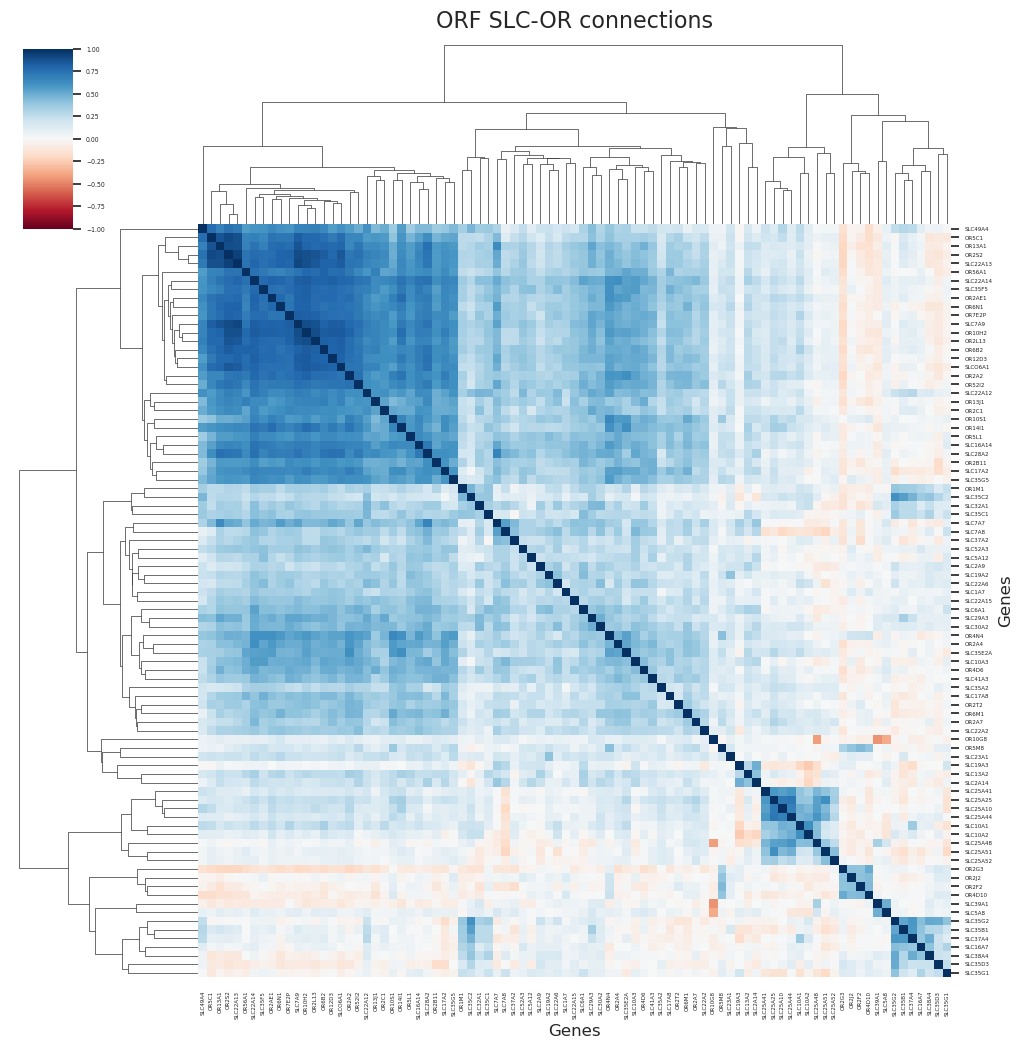

In [14]:
# Plot heatmap top similar genes

sns.set(rc={"figure.figsize": (48, 32)})
sns.set(font_scale=0.4)

f = sns.clustermap(
    orf_similarity_df, cmap="RdBu", vmin=-1, vmax=1, xticklabels=True, yticklabels=True
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=4)
f.ax_heatmap.yaxis.set_tick_params(labelsize=4)
f.ax_heatmap.set_title("ORF SLC-OR connections", fontsize=16, y=1.25)
f.savefig("figures/orf_slc-or-connections.png", dpi=300)
f.savefig("figures/orf_slc-or-connections.svg", dpi=300)

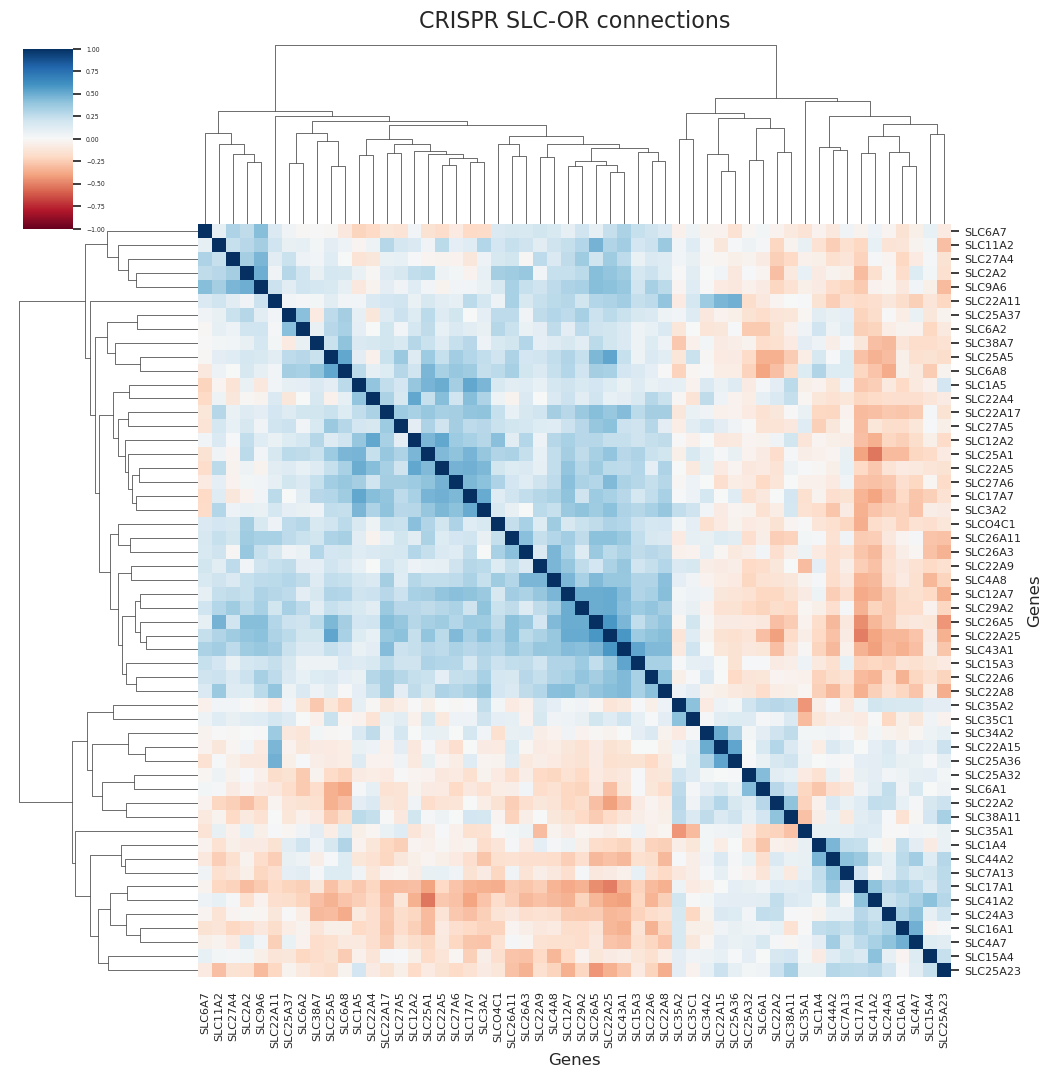

In [15]:
# Plot heatmap top similar genes

sns.set(rc={"figure.figsize": (48, 32)})
sns.set(font_scale=0.4)

f = sns.clustermap(
    crispr_similarity_df, cmap="RdBu", vmin=-1, vmax=1, xticklabels=True, yticklabels=True
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=8)
f.ax_heatmap.yaxis.set_tick_params(labelsize=8)
f.ax_heatmap.set_title("CRISPR SLC-OR connections", fontsize=16, y=1.25)
f.savefig("figures/crispr_slc-or-connections.png", dpi=300)
f.savefig("figures/crispr_slc-or-connections.svg", dpi=300)